In [ ]:
#!/usr/bin/python

__author__ = 'Elliot Simon'
__email__ = 'ellsim@dtu.dk'
__date__ = 'April 10, 2018'
__credits__ = ["DTU-Risø", "NCAR"]

## Configs

In [104]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import matplotlib.image as mpimg
from ipywidgets import interact, IntSlider, Dropdown, Checkbox
from scipy import signal
import cv2
import scipy.ndimage
from scipy.ndimage.interpolation import rotate

In [3]:
#%matplotlib notebook
%matplotlib inline

In [147]:
plt.style.use('classic')

plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['xtick.major.pad']='8'
plt.rcParams['ytick.major.pad']='8'

## Function definitions

In [5]:
# Function to get the starting column number for a specific range gate
def get_col_num(range_gate):
    colnum = int((((range_gate - 80)/20)*4)+8)
    return colnum

In [6]:
# Function to convert labview to datetime stamp
# Time is stamped at beginning of 10min period in UTC format!!!
def convtime(labviewtime):
    unixtime = labviewtime - 2082844800
    timestamp = datetime.datetime.utcfromtimestamp(int(unixtime)) - pd.Timedelta(minutes=10)
    # + pd.Timedelta(hours=1) 
    return timestamp

In [7]:
# Function to plot a flattened PPI image from polar coordinates
def plot_ppi(los_start=0, minscale=-20, maxscale=20, scalestep=1, cmap='seismic', cbar_bool=False):
    if los_start % 30 != 0:
        print('warning! los_start should be a multiple of 30')
    df = df_ws.iloc[los_start:los_start+30]
    timestamp = convtime(df.iloc[-1]['dt_stop']).strftime("%Y-%m-%d %H:%M:%S")
    range_gates = df.iloc[0:1,8::4].values[0].tolist()
    azims = df['azim'].tolist()
    azimuths = np.radians(azims)
    zeniths = range_gates
    r, theta = np.meshgrid(zeniths, azimuths)
    values = df[df.columns[9::4]]
    
    f = plt.figure(dpi=200)  # Size
    plt.tight_layout(pad=0)
    ax = plt.subplot(111, polar=True)  # Create subplot
        
    pp = plt.contourf(theta, r, values, vmin=minscale, vmax=maxscale, cmap=cmap, levels=np.arange(minscale,maxscale,scalestep))
    ax.set_theta_zero_location("N")
    if cbar_bool is True:
        cbar = plt.colorbar(pp, orientation='vertical')
        cbar.ax.set_ylabel('radial speed (m/s)')
    #plt.grid(color='#888888')
    ax.grid(False)
    plt.axis('off')
    ax.set_theta_direction(-1)
    #ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], color='#666666', fontsize=8)
    ax.spines['polar'].set_visible(False)
    plt.annotate(xy=(5.05,3500), s=('PPI Plot at: ' + timestamp), fontsize=10)
    
    plt.savefig('.\\temp\\' + str(los_start) + '.png', tight_layout=True, pad=0)
    plt.close('all')
    
    im = mpimg.imread('.\\temp\\' + str(los_start) + '.png')
    im_crop = crop_image(im)
    
    return im_crop

In [8]:
# Function to crop PPI image to remove whitespace
# Need to re-write this implementation, it's horribly inefficient
def crop_image(im):
    x_min = 350
    x_max = 650
    y_min = 200
    y_max = 400
    
    return im[y_min:y_max,x_min:x_max]

In [9]:
# Simple conversion between polar and cartesian
def pol2cart(theta, rho):
    theta = np.radians(theta)
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y

In [34]:
# Backend for 2D-xcorr widget
def plot_2d_xcorr(scan1, scan2, boundary, mode, plot_ppi_bool, title, regrid_bool):
    # Determine if we should re-grid or not
    if regrid_bool:
        # Get regridded dataframe
        s1 = conv_pol_cart(scan1)
        s2 = conv_pol_cart(scan2)
    else:
        # Slice up data by scan using slider inputs. Reset index required to match values
        s1 = df_rs.iloc[scan1:scan1+30, :].reset_index(drop=True)
        s2 = df_rs.iloc[scan2:scan2+30, :].reset_index(drop=True)
    
    # Subtract the mean to remove the pyramid, then divide by standard deviation (data normalization)
    s1 = (s1 - np.mean(s1, axis=0))/np.std(s1, axis=0)
    s2 = (s2 - np.mean(s2, axis=0))/np.std(s2, axis=0)
    
    #Scipy doesn't like NaNs
    valid1 = ~np.isnan(s1.values).any(axis=0)
    valid2 = ~np.isnan(s2.values).any(axis=0)
    
    scan1_val = s1.values[:, valid1]
    scan2_val = s2.values[:, valid2]
    
    #print('Scan 1 shape: ' + str(scan1_val.shape))
    #print('Scan 2 shape: ' + str(scan2_val.shape))
    
    corr = signal.correlate2d(scan1_val, scan2_val, boundary=boundary, mode=mode)
    #Plot the 2d xcorr
    
    f = plt.figure(dpi=200) 
    plt.tight_layout(pad=0)
    plt.imshow(corr, interpolation='bilinear', origin='lower')
    
    if regrid_bool:
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
    else:
        plt.xlabel('Radial distance')
        plt.ylabel('Azimuth angle')
    
    plt.title(title)
    # Find the position where max correlation occurs and annotate
    y, x = np.unravel_index(np.argmax(corr), corr.shape)
    plt.annotate('+', (x, y))
    # Get axis limits so we can denote actual center
    y1, y2 = plt.gca().get_ylim()
    x1, x2 = plt.gca().get_xlim()
    c_x = (x1+x2)/2
    c_y = (y1+y2)/2
    plt.annotate('.', (c_x, c_y))
    
    plt.colorbar()
    plt.clim(0,None)
    plt.show()
    
    if plot_ppi_bool:

        #Plot PPI images alongside
        f = plt.figure()
        plt.tight_layout()
        plt.subplot(121)
        im1 = plot_ppi(los_start=scan1)
        plt.imshow(im1)
        plt.axis('off')
        plt.show()

        plt.subplot(122)
        plt.tight_layout()
        im2 = plot_ppi(los_start=scan2)
        plt.imshow(im2)
        plt.axis('off')
        plt.show()
    
    return scan1_val.shape, scan2_val.shape, (x,y)
    #return scan1_val, scan2_val

In [ ]:
# backup polar2cartesian
def polar2cartesian(outcoords, inputshape, origin, angular_width=30):
    # Modified from ptomato on stack overflow. Thanks!
    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    #theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))
    # Allows us to define our transformation size if not a full PPI
    theta_index = np.round((theta + np.pi) * inputshape[1] / (np.pi/(180/angular_width)))

    return (r,theta_index)

In [11]:
# Transform coordinate systems from polar to cartesian
# Input is the starting line of sight number. Outputs regridded dataframe
def conv_pol_cart(los_start=0, order=0):
    if los_start % 30 != 0:
        print('warning! los_start should be a multiple of 30')
    df_polar = df_rs.iloc[los_start:los_start+30]
    df_polar = df_polar.set_index(azims)

    df_polar_cart = scipy.ndimage.geometric_transform(df_polar, polar2cartesian, 
    order=order,
    output_shape = (df_polar.shape[0] * 2, df_polar.shape[0] * 2),
    extra_keywords = {'inputshape':df_polar.shape,
        'origin':(df_polar.shape[0], df_polar.shape[0])})
    # Convert ndarray to pd dataframe
    df_polar_cart = pd.DataFrame(df_polar_cart)
    return df_polar_cart

## Processing

In [74]:
%%time
# Read in windscanner wind_data file
df_ws = pd.read_csv('E:\\LASCAR\\sirocco\\merged_wind_all_scenarios\\processed\\20171114153902_PPI1_merged.txt', sep=';', header=None)

Wall time: 43.7 s


In [75]:
# Rename azim and elevation columns
df_ws = df_ws.rename(columns={5: 'dt_stop', 6: 'azim', 7: 'elev'})

In [76]:
# Gets list of range gates to use for plotting radial distances
range_gates = df_ws.iloc[0:1,8::4].values[0].tolist()

In [122]:
# Loops through list of range gates. Applies CNR mask to set radspeed to NaN if CNR < -25
for dist in range_gates:
    rg = get_col_num(dist)
    mask = df_ws[rg+2] < -25
    df_ws.loc[mask, rg+1] = np.nan

    mask = df_ws[rg+2] > 0
    df_ws.loc[mask, rg+1] = np.nan

In [123]:
# Loops through list of range gates. Applies RS mask to set radspeed to NaN if RS >= 0
for dist in range_gates:
    rg = get_col_num(dist)
    mask = df_ws[rg+1] >= 0
    df_ws.loc[mask, rg+1] = np.nan

In [124]:
# Get list of azims for this scan for plotting azimuths
# Round to 3 decimal places for floating point errors
df = df_ws.iloc[0:30]
azims = df['azim'].tolist()
azims = np.round(azims, 3)

In [125]:
# Take only the radial speed data
# Apply absolute value to make them positive
df_rs = df_ws[df_ws.columns[9::4]]
df_rs = df_rs.abs()
df_rs.columns = range_gates

## Plotting

In [117]:
# Chop up into scan by scan (30 lines for LASCAR)
df = df_ws.iloc[0:30]

In [118]:
azimuths = np.radians(azims)
zeniths = range_gates

In [119]:
r, theta = np.meshgrid(zeniths, azimuths)
values = df[df.columns[9::4]]

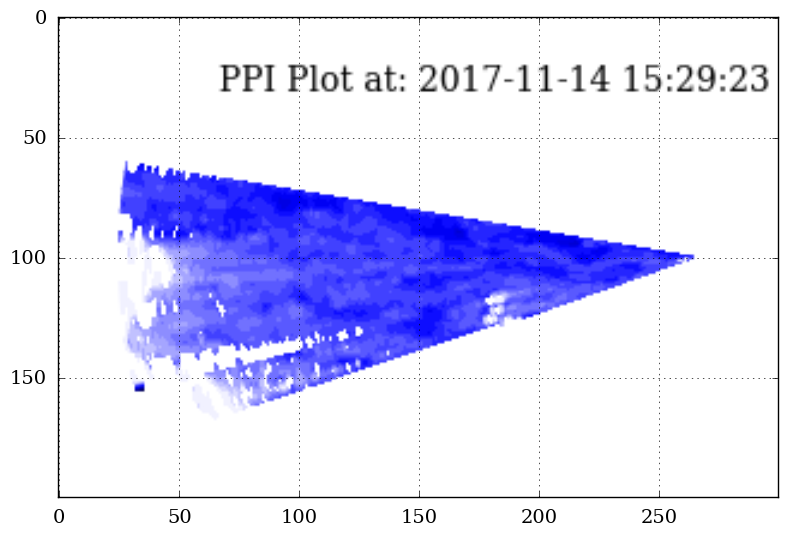

In [127]:
im = plot_ppi(los_start=0)
#im = crop_image(im)
plt.imshow(im)

## Batch plot PPIs and save

In [ ]:
minscale = -20
maxscale = 20
scalestep = 1

azim_low = azims[0]
azim_high = azims[-1]

In [ ]:
%%time
# Loop through and plot all scans
zeniths = range_gates
scannum = 0

for i in range(0,len(df_ws),30):
    df = df_ws.iloc[i:i+30]
    azims = df['azim'].tolist()
    
    azimuths = np.radians(azims)
    
    r, theta = np.meshgrid(zeniths, azimuths)
    values = df[df.columns[9::4]]
    
    timestamp = convtime(df['dt_stop'].iloc[-1]).strftime("%Y-%m-%d %H:%M:%S")
    filename = convtime(df['dt_stop'].iloc[-1]).strftime("%Y-%m-%d-%H-%M-%S")
        
    plt.figure(figsize=(7, 7))  # Size
    ax = plt.subplot(111, polar=True)  # Create subplot

    pp = plt.contourf(theta, r, values, vmin=minscale, vmax=maxscale, cmap='seismic', levels=np.arange(minscale,maxscale,scalestep))
    
    ax.set_theta_zero_location("N")
    cbar = plt.colorbar(pp, orientation='vertical')
    cbar.ax.set_ylabel('radial speed (m/s)')
    plt.grid(color='#888888')
    ax.set_theta_direction(-1)
    ax.set_thetamin(azim_low)
    ax.set_thetamax(azim_high)
    #ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], color='#666666', fontsize=8)
    ax.set_xticklabels(['','','','','W'], color='#666666', fontsize=8)
    ax.spines['polar'].set_visible(False)

    plt.suptitle(timestamp + ' UTC' + '\n \n LASCAR Campaign, DTU-RISØ \n ellsim@dtu.dk', fontsize=12)
    
    plt.savefig('.\\plots\\ppi_plots\\20171030194350_PPI1_merged\\ppi_plot_filt_'+str(scannum)+'_'+str(filename)+'.png')
    
    plt.close('all')
    
    scannum += 1

In [ ]:
'E:\\LASCAR\\sirocco\\merged_wind_all_scenarios\\20171030194350_PPI1_merged.txt'.split('.')[-2].split('\\')[-1]

## 2D Cross Corr

In [ ]:
# Plot heatmap of all data
C = np.ma.masked_where(np.isnan(df_rs.transpose()),df_rs.transpose())
im = plt.pcolormesh(C, vmin=-20, vmax=20, cmap='seismic')

In [ ]:
corr = signal.correlate2d(df_rs.values[0:30], df_rs.values[30:60])

In [ ]:
#Find max 
y, x = np.unravel_index(np.argmax(corr), corr.shape)

In [ ]:
print(x,y)

## Interactive 2D corr

In [64]:
# Run widget
max_los = len(df_rs)-30
interact(plot_2d_xcorr, 
         scan1=IntSlider(value=0, min=0, max=max_los, step=30), 
         scan2=IntSlider(value=30, min=0, max=max_los, step=30), 
         boundary = Dropdown(options=['symm', 'fill', 'wrap'], value='symm', description='Boundary:'),
         mode = Dropdown(options=['same', 'full', 'valid'], value='same', description='Mode:'),
         plot_ppi_bool = Checkbox(value=False, description='Plot PPIs alongside?'),
         regrid_bool = Checkbox(value=True, description='Regrid?'),
         title='2D Cross Correlation');

In [ ]:
s1,s2 = plot_2d_xcorr(0,30,boundary='symm', mode='same', plot_ppi_bool=False, title='PPI', regrid_bool=True);

## Reproject Polar to Cartesian

In [146]:
# Widget to display re-gridded PPI
max_los = len(df_rs)-30
interact(conv_pol_cart_image, 
         los_start=IntSlider(value=0, min=0, max=max_los, step=30), 
         order=IntSlider(value=0, min=0, max=1, step=1),
         cmap=Dropdown(value='hot_r', options=['hot_r', 'jet', 'seismic_r']),
         vmin=IntSlider(value=0, min=-30, max=30, step=1),
         vmax=IntSlider(value=15, min=-30, max=30, step=1),
        );

In [116]:

def polar2cartesian(outcoords, inputshape, origin, angular_width=30):
    # Modified from ptomato on stack overflow. Thanks!
    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    #theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))
    # Allows us to define our transformation size if not a full PPI
    theta_index = np.round((theta + np.pi) * inputshape[1] / (np.pi/(180/angular_width)))

    return (r,theta_index)

In [158]:
# Transform coordinate systems from polar to cartesian and plot image
# Input is the starting line of sight number. Outputs is an image, and re-gridded data is returned
def conv_pol_cart_image(los_start=0, order=0, title='PPI', cmap='hot_r', vmin=0, vmax=15):
    if los_start % 30 != 0:
        print('warning! los_start should be a multiple of 30')

    df_polar = df_rs.iloc[los_start:los_start+30]
    df_polar = df_polar.set_index(azims)

    df_polar_cart = scipy.ndimage.geometric_transform(df_polar, polar2cartesian, 
    order=order,
    output_shape = (df_polar.shape[0] * 2, df_polar.shape[0] * 2),
    extra_keywords = {'inputshape':df_polar.shape,
        'origin':(df_polar.shape[0], df_polar.shape[0])})
    
    # Rotate our dataframe so that it's the right way around
    #df_polar_cart = df_polar_cart.T
    #df_polar_cart = rotate(df_polar_cart, 60)
    
    # Convert ndarray to pd dataframe
    df_polar_cart = pd.DataFrame(df_polar_cart)
    
    f = plt.figure()
    plt.title(title)
    plt.imshow(df_polar_cart, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='bilinear')
    plt.colorbar()
    plt.show()
    return df_polar_cart

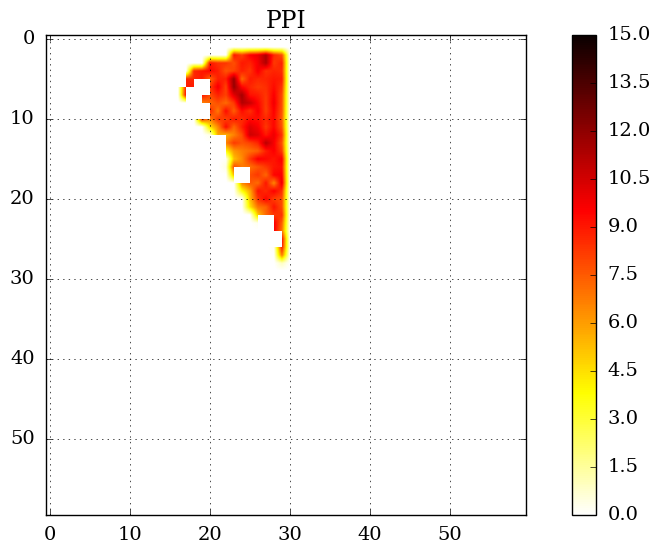

In [167]:
df_cart = conv_pol_cart_image(600)